<h2>Base case with 2 calibrations and 2 job types</h2>
Consider a problem of scheduling certain number of jobs that can have 2 possible execution times, on a single machine that needs occasional calibration. Once calibrated, machine stays in calibrated state for some interval of time that can take 2 possible lengths. Jobs cannot be executed unless the machine is in calibrated state.

<h3>Step 1 : Initialization </h3>

In [6]:
from functools import lru_cache
import random, pprint
pp = pprint.PrettyPrinter()

job_types=range(2)  #2 job types
cal_types=range(2)  #2 calibration types
cal_len=[] #lengths of calibrations
job_nb=[]  #numbers of jobs of each type
job_len=[] #lengths of jobs of each type
cost_cal=0  #calibration cost
cost_prob=0  #probing cost
inp = int(input('Please enter 1 for user input, and 0 for automatically generated input '))

if(inp==1):
    j1 = int(input('Please input the length of the shorter job '))
    j2=int(input('Please input the length of the longer job '))
    job_len.extend((j1,j2))
    n1 = int(input('Please input the number of the shorter jobs '))
    n2=int(input('Please input the number of the longer jobs '))
    job_nb.extend((n1,n2))
    job_nb=tuple(job_nb)
    d1 = int(input('Please input the length of the shorter calibration '))
    d2=int(input('Please input the length of the longer calibration '))
    cal_len.extend((d1,d2))
    cal_len=tuple(cal_len)
    cost_cal=int(input('Please input the calibration cost '))
    cost_prob=int(input('Please input the probing cost '))
else:
    job_nb = tuple(random.randint(10,20) for _ in job_types)			# has to be a tuple for lru_cache
    job_len = [random.randint(10, 15) + 15* i for i in job_types]
    cal_len = [random.randint(40,50) + 20 * i for i in cal_types]
    cal_len.sort()  # just make sure the shortest one has index 0
    cal_len=tuple(cal_len)
    cost_cal = random.randint(100,150)
    cost_prob = random.randint(30, 50)
    

<h3>Step 2: Maximal packings</h3>
Compute for each calibration type, vectors of numbers of jobs that would fit in an interval of its length. Vectors are maximal in the sense that incrementing any of the job numbers would exceed the interval capacity


In [7]:
def fit_max(cal_len,job_len): #maximal packings function
    max_fit = [[] for ell in cal_types]
    for j, ell in enumerate(cal_len):
        for i0 in range(ell // job_len[0] + 1): 	# +1 because we want to include this last value
            i1 = (ell - i0 * job_len[0]) // job_len[1]
            max_fit[j].append([i0, i1])
    return max_fit

max_fit = fit_max(cal_len,job_len)
print("Maximal Coverings of calibration of length " + str(cal_len[0])+ " is " + str(max_fit[0]))
print("Maximal Coverings of calibration of length " + str(cal_len[1])+ " is " + str(max_fit[1]))
#pp.pprint(max_fit)

Maximal Coverings of calibration of length 41 is [[0, 1], [1, 1], [2, 0], [3, 0]]
Maximal Coverings of calibration of length 65 is [[0, 2], [1, 1], [2, 1], [3, 1], [4, 0], [5, 0]]


<h3>Step 3: Scheduling functions - proposed and random schedule</h3>

In [8]:
@lru_cache(maxsize=None) 
def schedule(remaining, cost_cal, cost_prob):
	
	"""
	Solves optimally the scheduling problem with the given remaining
	number of jobs of each type.

	Returns a couple (exp_cost, sample_sch), where exp_cost is the expected
	cost of the produced schedule and sample_sch is the description  of
	one scenario of this schedule. The later consiste in a list of
	couples (technically 2-element lists). Every couple [t, v] describes
	one calibration interval. If t == -1, then the interval is not probed,
	and otherwise it is probed and t is its type. The vector v describes
	how many jobs of each type are packed into this interval.
	"""
    
	if sum(remaining) == 0:
		# no jobs to schedule
		return (0, [])

	# compute for each calibration type the schedule optimizing the expected cost
	opt_sch = [(float('inf'), []) for _ in cal_types]
	for i in cal_types:       
		# an alternative is of the form [e, s], 
		# where e is the expected cost, 
		# and s a sampled schedule with the restriction 
		# that the first interval is of type i.
		# try all possibilities to pack jobs into this first interval
		for u in max_fit[i]:
			# v0 is the actual packing vector, taking into account availabilities
			v0 = [min(remaining[j], u[j]) for j in job_types]
			if sum(v0):			# ignore empty packings
				v1 = tuple(remaining[j] - v0[j] for j in job_types)
				# schedule optimally v1, the vector of remaining jobs, once v0 is packed
				cost, sch = schedule(v1, cost_cal, cost_prob)
				alt = (cost_cal + cost, [[i, v0]] + sch)	# consider this alternative
				if alt < opt_sch[i]:
					opt_sch[i] = alt
	
	# Compare 2 alternatives

	
	# alternative 1: probe
	# compute expected cost, by averaging 
	exp_cost = cost_prob + sum(opt_sch[i][0] for i in cal_types) / len(cal_types)
	# compare with alternative 2: don't probe, use calibration type 0
	if exp_cost < opt_sch[0][0]:	
		# sample one scenario
		i = random.choice(cal_types)
		return (exp_cost, opt_sch[i][1])
	else:
		# alternative 2: don't probe, use type 0 interval
		
		# 0=calibration type, 1=schedule, 0=first interval, 0=type of this interval
		opt_sch[0][1][0][0] = -1 # indicate that we don't probe; shortest calibration, value for the first job type = -1
		# it is ok to modify this object as it is not used in another context
		return opt_sch[0]

In [9]:
#random schedule, similar to the previous one but selects alternatives randomly 
@lru_cache(maxsize=None) 
def schedule_rdn(remaining, cost_cal, cost_prob):
    
	if sum(remaining) == 0:
		# no jobs to schedule
		return (0, [])

	# compute for each calibration type the schedule optimizing the expected cost
	opt_sch = [(float('inf'), []) for _ in cal_types]
	for i in cal_types:       
		# an alternative is of the form [e, s], 
		# where e is the expected cost, 
		# and s a sampled schedule with the restriction 
		# that the first interval is of type i.
		# try all possibilities to pack jobs into this first interval
		for u in max_fit[i]:
			# v0 is the actual packing vector, taking into account availabilities
			v0 = [min(remaining[j], u[j]) for j in job_types]
			if sum(v0):			# ignore empty packings
				v1 = tuple(remaining[j] - v0[j] for j in job_types)
				# schedule optimally v1, the vector of remaining jobs, once v0 is packed
				cost, sch = schedule_rdn(v1, cost_cal, cost_prob)
				alt = (cost_cal + cost, [[i, v0]] + sch)	# consider this alternative
				if alt < opt_sch[i]:
					opt_sch[i] = alt
	
	#  2 alternatives based on the value of choice that is random

	
	# alternative 1: probe
	# compute expected cost, by averaging
	choice = random.randint(0,1)
	exp_cost = cost_prob + sum(opt_sch[i][0] for i in cal_types) / len(cal_types)
    
	if choice==0:	
		# probing
		i = random.choice(cal_types)
		return (exp_cost, opt_sch[i][1])
	else:
		# alternative 2: don't probe, use type 0 interval
		
		# 0=calibration type, 1=schedule, 0=first interval, 0=type of this interval
		opt_sch[0][1][0][0] = -1 # indicate that we don't probe; shortest calibration, value for the first job type = -1
		# it is ok to modify this object as it is not used in another context
		return opt_sch[0]

<h3> Step 4: Representations of the schedules </h3>

In [10]:
print(f"instance {job_nb=} {job_len=} {cal_len=} {cost_cal=} {cost_prob=}")
print("\nProbing based on minimizing expected cost")
pp.pprint(schedule(job_nb, cost_cal, cost_prob))
print("\nRandomly probing")
pp.pprint(schedule_rdn(job_nb, cost_cal, cost_prob))

instance job_nb=(14, 13) job_len=[11, 29] cal_len=(41, 65) cost_cal=105 cost_prob=50

Probing based on minimizing expected cost
(1465.0006103515625,
 [[1, [0, 2]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [3, 0]]])

Randomly probing
(1535.0,
 [[-1, [0, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [1, [2, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [-1, [1, 1]],
  [1, [3, 1]],
  [-1, [1, 1]],
  [-1, [0, 1]]])


<h3> Step 5: Analysing properties of schedules </h3>

<h5> 5.1 Probing rank refers to an index of an interval in a schedule after which scheduler does not probe anymore. If probing rank exists in a schedule, we mark it as 1, if it does not exist -1, and if a scheduler does not probe at all, we label 0. Consider 121 randomly generated schedules of fixed job lengths and calibration lengths.</h5>


In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#funcion finds the first interval that is not probed = probing rank
#function returns 1 we don't proble after probing rank, -1 if we do, 0 if we don't probe at all
def algo_choice(solution):
    result=[0]*2
    schedule = solution[1]
    first_el=[item[0] for item in schedule]
    idx = -1
    find=1
    try:
        idx = first_el.index(-1)
        idx = idx+1
        for el in first_el[idx::]:
            if(el!=-1):
                find=-1
                break
    
    except ValueError:
        find=0
        
    return find

#plot 
z= []
for i in range(10,21):
    for j in range(10,21):   
        job_nb_ = tuple([i,j])
        c_c = random.randint(100,200)
        c_p = random.randint(20, 50)
        res = schedule(job_nb_, c_c, c_p)
        t = algo_choice(res)
        z.append(t)
        
i = z.count(-1)
j=z.count(1)
z = np.array(z)
print(f"instance {job_len=} {cal_len=} ")
print("1 indicates that algorithm does not probe after some interval (pattern present),\n-1 indicates that it does (pattern not present),\n0 indicates that it does not probe at all in this schedule(inconclusive)\n")
pp.pprint(z)
print("Number of 0s: "+str(121-i-j))
print("Number of 1s: "+str(j))
print("Number of -1s: "+str(i))

instance job_len=[11, 29] cal_len=(41, 65) 
1 indicates that algorithm does not probe after some interval (pattern present),
-1 indicates that it does (pattern not present),
0 indicates that it does not probe at all in this schedule(inconclusive)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Number of 0s: 4
Number of 1s: 117
Number of -1s: 0


<h6> Conclusion: Probing rank exists in majority of the schedules </h6>

<h5> 5.2 Estimate the average probing probability of an interval based on the ratio between calibration in probing cost. Consider 121 randomly generated schedules of fixed job lengths, job numbers and calibration lengths.</h5>

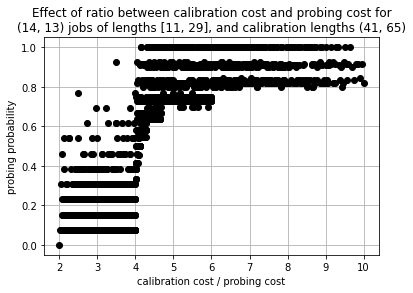

In [12]:
def prob_prob(job_nb):
    x=[]
    y=[]
    for c_c in range(100,201):
        for c_p in range(20,51):
            res=schedule(job_nb, c_c, c_p)
            res1 = res[1]
            first_el=[item[0] for item in res1]
            unprobed=first_el.count(-1)
            p2=1-unprobed/len(first_el)
            x.append(c_c/c_p)
            y.append(p2)
    return x,y

X, Y = prob_prob(job_nb)
plt.plot(X, Y, 'o', color='black');
plt.grid(True)
plt.ylabel('probing probability')
plt.xlabel('calibration cost / probing cost')
plt.title('Effect of ratio between calibration cost and probing cost for\n'+str(job_nb)+' jobs of lengths '+str(job_len)+', and calibration lengths '+str(cal_len))
plt.show()  

<h6> Conclusion: Maximimum value of a probing probability of a set of schedules with same calibration cost / probing cost ratio is directly proportional to the calibration cost/probing cost ratio

<h3>Step 6: Performance comparison of two schedulers</h3>

<h5> Comparing the performance of 121 pairs of schedules generated by proposed and random schedulers. Job numbers range from 10 to 20. Calibration and probing costs are randomly generated for each pair Job lengths and calibration lengths are fixed. Each entry in the output array refers to the percentage difference in costs between proposed and random schedule. <h5>

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#comparing the costs random scheduler with proposed scheduler
def algo_rdn(sch1, sch2):
    result=[0]*2
    cost1 = sch1[0]
    cost2 = sch2[0]
    diff = (cost2-cost1)/cost2
    return diff*100
    

#plot 
z= []
for i in range(10,21):
    for j in range(10,21):   
        job_nb_ = tuple([i,j])
        c_c = random.randint(100,200)
        c_p = random.randint(20, 50)
        t = algo_rdn(schedule(job_nb_, c_c, c_p), schedule_rdn(job_nb_, c_c, c_p))
        z.append(t)
        
i = z.count(-1)
j=z.count(1)
z = np.array(z)
print(f"instance {job_len=} {cal_len=} ")
pp.pprint(z)

instance job_len=[11, 29] cal_len=(41, 65) 
array([4.5430945 , 0.        , 3.01334495, 2.23521629, 2.46593768,
       0.97664126, 3.56479809, 3.51770895, 1.30388433, 2.58291228,
       2.80068216, 4.5887746 , 5.03169906, 5.72555897, 4.45469081,
       3.73603239, 3.33822609, 3.23053547, 4.566336  , 1.29993701,
       2.79797244, 3.16019935, 2.20222771, 2.44460388, 1.55685954,
       3.78970026, 3.42653941, 4.53688238, 3.12003814, 1.2078151 ,
       2.7236345 , 1.39087911, 5.7589733 , 2.12667834, 3.2245809 ,
       3.1707808 , 4.74986719, 4.69476113, 2.20819186, 3.62798568,
       3.21332049, 1.43595122, 2.32888006, 2.53962222, 2.48691712,
       3.21361059, 3.49303485, 0.55787618, 5.42127913, 3.86359023,
       3.36927   , 1.80798939, 2.79219647, 1.21503737, 1.45124127,
       1.33454814, 3.45119281, 1.94190751, 4.35901992, 1.8648614 ,
       4.32855862, 2.43602845, 3.00673312, 0.95469881, 3.70004231,
       2.79232254, 2.70708709, 0.68809807, 4.13175823, 0.91800714,
       2.93584969,